# Databases
#### #1
- Name: Gas Sensor Array Drift Dataset Data Set
- Data Set Characteristics: Multivariate
- Number of Instances: 13910
- Area: Computer
- Attribute Characteristics: Real
- Number of Attributes: 128
- Date Donated: 2012-04-25
- Associated Tasks: Classification
- Missing Values? No
- Number of Web Hits: 147103
- Link: https://archive.ics.uci.edu/ml/datasets/Gas+Sensor+Array+Drift+Dataset

#### #2
- Name: Insurance Company Benchmark (COIL 2000) Data Set
- Data Set Characteristics: Multivariate
- Number of Instances: 9000
- Area: Social
- Attribute Characteristics: Categorical, Integer
- Number of Attributes: 86
- Date Donated: 2000-07-03
- Associated Tasks: Regression, Description
- Missing Values? No
- Number of Web Hits: 161966
- Link: http://archive.ics.uci.edu/ml/datasets/Insurance+Company+Benchmark+%28COIL+2000%29

#### #3
- Name: Breast Cancer Wisconsin (Diagnostic) Data Set
- Data Set Characteristics: Multivariate
- Number of Instances: 569
- Area: Life
- Attribute Characteristics: Real
- Number of Attributes: 32
- Date Donated: 1995-11-01
- Associated Tasks: Classification
- Missing Values? No
- Number of Web Hits: 1392853
- Link: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

#### #4
- Name: Online News Popularity Data Set
- Data Set Characteristics:  
- Multivariate
- Number of Instances: 39797
- Area: Business
- Attribute Characteristics: Integer, Real
- Number of Attributes: 61
- Date Donated: 2015-05-31
- Associated Tasks: Classification, Regression
- Missing Values? No
- Number of Web Hits: 312185
- Link: https://archive.ics.uci.edu/ml/datasets/Online+News+Popularity

#### #5
- Name: Epileptic Seizure Recognition Data Set
- Data Set Characteristics: Multivariate, Time-Series
- Number of Instances: 11500
- Area: Life
- Attribute Characteristics: Integer, Real
- Number of Attributes: 179
- Date Donated: 2017-05-24
- Associated Tasks: Classification, Clustering
- Missing Values? No
- Number of Web Hits: 122456
- Link: https://archive.ics.uci.edu/ml/datasets/Epileptic+Seizure+Recognition

In [2]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier

from deslib.static.oracle import Oracle
from marianaasouza.sgh import SGH
from reference.rlo.rlo import random_linear_oracle

#### Notes
- For Random Linear Oracle, was used a version implemented by Leonardo Alves (las3). Thank you !

## Database pre-processing

### Gas Sensor Array Drift

In [3]:
def parse_cell(cell_value):
    value = str(cell_value).split(":")
    return value[1] if len(value) > 1 else value[0]

gas_n_batch = 10
gas_base_batch_name = "batch{}.dat"
gas_batch_filenames = [gas_base_batch_name.format(i) for i in range(1, gas_n_batch+1)]

gas_dataframes = []
for filename in gas_batch_filenames:
    df = pd.read_csv("./databases/gas-sensor-array-drift/" + filename, header=None, sep=" ")
    gas_dataframes.append(df)

gas_data = pd.concat(gas_dataframes, axis=0, ignore_index=True)
gas_n_row, gas_n_column = gas_data.shape
gas_columns = ['y'] + ["X{}".format(i) for i in range(0, gas_n_column-1)]
gas_data.columns = gas_columns
gas_data = gas_data.applymap(lambda x: parse_cell(x))
gas_data = gas_data.apply(pd.to_numeric, errors='ignore')

gas_data["y"] = gas_data["y"].apply(lambda x: x - 1)

gas_data.head()

,y,X0,X1,X2,X3,X4,X5,X6,X7,X8,...,X118,X119,X120,X121,X122,X123,X124,X125,X126,X127
0,0,15596.1621,1.868245,2.371604,2.803678,7.512213,-2.739388,-3.344671,-4.847512,15326.6914,...,-1.071137,-3.037772,3037.0390,3.972203,0.527291,0.728443,1.445783,-0.545079,-0.902241,-2.654529
1,0,26402.0704,2.532401,5.411209,6.509906,7.658469,-4.722217,-5.817651,-7.518333,23855.7812,...,-1.530519,-1.994993,4176.4453,4.281373,0.980205,1.628050,1.951172,-0.889333,-1.323505,-1.749225
2,0,42103.5820,3.454189,8.198175,10.508439,11.611003,-7.668313,-9.478675,-12.230939,37562.3008,...,-2.384784,-2.867291,5914.6685,5.396827,1.403973,2.476956,3.039841,-1.334558,-1.993659,-2.348370
3,0,42825.9883,3.451192,12.113940,16.266853,39.910056,-7.849409,-9.689894,-11.921704,38379.0664,...,-2.607199,-3.058086,6147.4744,5.501071,1.981933,3.569823,4.049197,-1.432205,-2.146158,-2.488957
4,0,58151.1757,4.194839,11.455096,15.715298,17.654915,-11.083364,-13.580692,-16.407848,51975.5899,...,-3.594763,-4.181920,8158.6449,7.174334,1.993808,3.829303,4.402448,-1.930107,-2.931265,-4.088756


### Insurance Company Benchmark

In [4]:
insurance_train_file = "ticdata2000.txt"
insurance_test_file = "ticeval2000.txt"
insurance_test_labels_file = "tictgts2000.txt"

insurance_train_data = pd.read_csv("./databases/insurance-company-benchmark/" + insurance_train_file, header=None, sep="\t")
insurance_test_data = pd.read_csv("./databases/insurance-company-benchmark/" + insurance_test_file, header=None, sep="\t")
insurance_test_labels_data = pd.read_csv("./databases/insurance-company-benchmark/" + insurance_test_labels_file, header=None, sep="\t")

insurance_test_data = pd.concat([insurance_test_data, insurance_test_labels_data], axis=1, ignore_index=True)
insurance_data = pd.concat([insurance_train_data, insurance_test_data], axis=0, ignore_index=True)

insurance_n_row, insurance_n_column = insurance_data.shape
insurance_columns = ["X{}".format(i) for i in range(0, insurance_n_column-1)] + ["y"]
insurance_data.columns = insurance_columns

insurance_data.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X76,X77,X78,X79,X80,X81,X82,X83,X84,y
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,0


### Breast Cancer Wisconsin (Diagnostic)

In [5]:
wdbc_data = pd.read_csv("./databases/wdbc/wdbc.data", header=None)
del wdbc_data[0]
wdbc_n_row, wdbc_n_column = wdbc_data.shape
wdbc_columns = ["y"] + ["X{}".format(i) for i in range(0, wdbc_n_column-1)]
wdbc_data.columns = wdbc_columns
wdbc_data["y"] = wdbc_data["y"].apply(lambda x: 0 if x == "M" else 1)
wdbc_data.head()

,y,X0,X1,X2,X3,X4,X5,X6,X7,X8,...,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29
0,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### Online News Popularity

In [6]:
popularity_data = pd.read_csv("./databases/online-news-popularity/OnlineNewsPopularity.csv")
popularity_data = popularity_data.drop(columns=["url"])
popularity_data.columns = list(map(lambda x: x.strip(), popularity_data.columns))
popularity_data["y"] = popularity_data["shares"].apply(lambda x: 0 if x < 1400 else 1)
popularity_data.head()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,y
0,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,...,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593,0
1,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,...,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711,0
2,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,...,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500,1
3,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,...,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200,0
4,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,...,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505,0


### Epileptic Seizure Recognition

In [7]:
epileptic_data = pd.read_csv("./databases/epileptic-seizure-recognition/data.csv")
epileptic_n_row, epileptic_n_column = epileptic_data.shape
epileptic_columns = ["X{}".format(i) for i in range(0, epileptic_n_column-1)] + ["y"]
epileptic_data.columns = epileptic_columns
epileptic_data = epileptic_data.drop(columns=["X0"])

epileptic_data["y"] = epileptic_data["y"].apply(lambda x: x - 1)

epileptic_data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,135,190,229,223,192,125,55,-9,-33,-38,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,3
1,386,382,356,331,320,315,307,272,244,232,...,164,150,146,152,157,156,154,143,129,0
2,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,57,64,48,19,-12,-30,-35,-35,-36,4
3,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,4
4,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,...,4,2,-12,-32,-41,-65,-83,-89,-73,4


### Databases characteristics and class distribution

Bases de dados utilizadas neste trabalho, ordenadas pela quantidade de instâncias:

Database | # Instances | # Attributes | # Classes
------ | ------ | ------ | ------
Breast Cancer Wisconsin (Diagnostic) | **569** | **32** | **2**
Insurance Company Benchmark | **9000** | **86** | **2**
Epileptic Seizure Recognition | **11500** | **179** | **5**
Gas Sensor Array Drift | **13910** | **128** | **6**
Online News Popularity | **39797** | **61** | **2**

In [89]:
import collections

def plot_class_distribution(class_data, database_name):
    %matplotlib inline
    plt.figure(figsize=(8,6))
    
    instances = dict(collections.Counter(list(class_data)))
    instances = collections.OrderedDict(sorted(instances.items()))
    instances = [i[1] for i in list(instances.items())]
    
    plt.bar(list(class_data.unique()), instances)
    plt.title("{}: Class distribution".format(database_name))
    plt.ylabel("# of instances")
    plt.xlabel("Classes")
    plt.xticks(list(class_data.unique()))

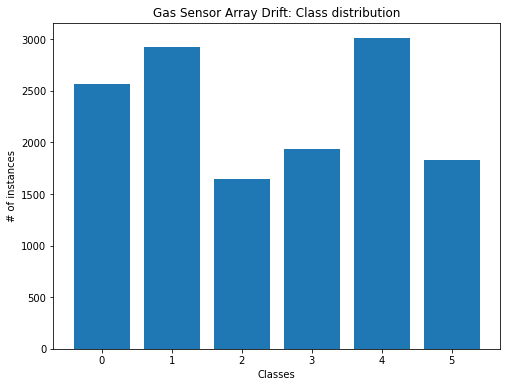

In [90]:
plot_class_distribution(gas_data["y"], "Gas Sensor Array Drift")

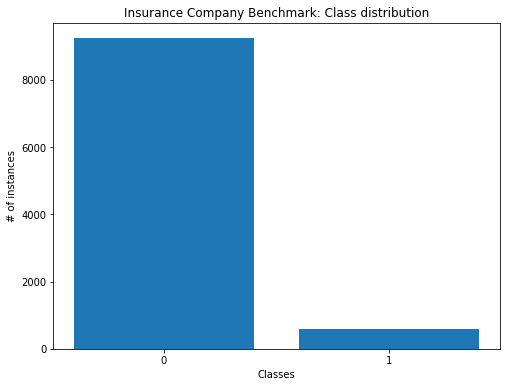

In [91]:
plot_class_distribution(insurance_data["y"], "Insurance Company Benchmark")

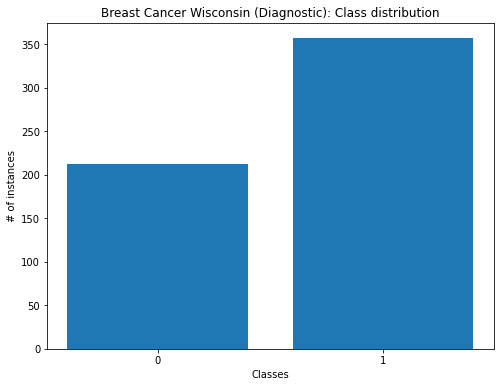

In [92]:
plot_class_distribution(wdbc_data["y"], "Breast Cancer Wisconsin (Diagnostic)")

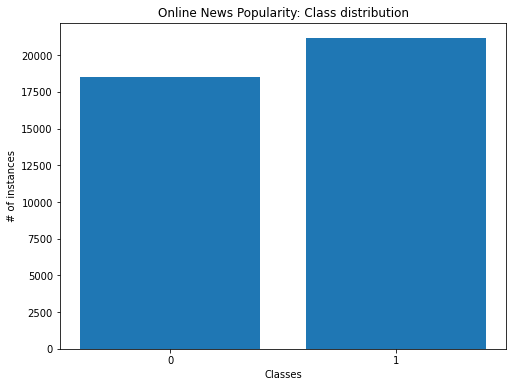

In [93]:
plot_class_distribution(popularity_data["y"], "Online News Popularity")

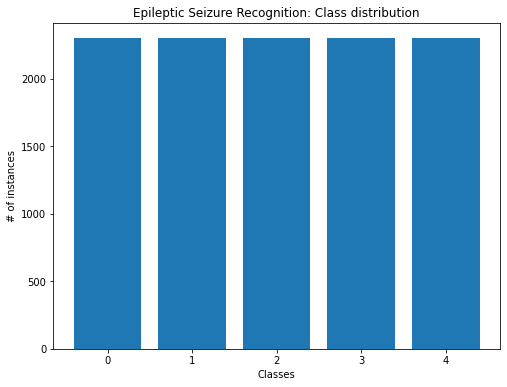

In [95]:
plot_class_distribution(epileptic_data["y"], "Epileptic Seizure Recognition")

### Experimentation methods
- run_ensemble_method: Choose and build an Ensemble method, given pool size and k value for k-fold cross validation
- evaluate_ensemble_method: Normalize the data, split in k-folds (equal distribution for class), generate the pool with classifier and evaluate with Oracle
- oracle_for_random_subspace: A special method to calculate Oracle for Random Subspace ensemble method, based on: https://github.com/amorimlb/Doc_MCS/

In [17]:
random_state = 42

def run_ensemble_method(X, y, ensemble_name, n_pool=10, kfold=5):
    print("Running {} ensemble. Pool = {}. K-fold = {}".format(ensemble_name, n_pool, kfold))
    ensemble_method = None
    
    perceptron = CalibratedClassifierCV(Perceptron(random_state=random_state))
    
    if ensemble_name == "Bagging":
        ensemble_method = BaggingClassifier(perceptron, n_estimators=n_pool, n_jobs=-1, verbose=0, 
                                            random_state=random_state)
    elif ensemble_name == "AdaBoost":
        ensemble_method = AdaBoostClassifier(perceptron, n_estimators=n_pool, random_state=random_state)
    elif ensemble_name == "Random Subspace":
        ensemble_method = BaggingClassifier(perceptron, n_estimators=n_pool, bootstrap=False, max_features=0.5, 
                                            n_jobs=-1, verbose=0, random_state=random_state)
    elif ensemble_name == "RLO":
        ensemble_method = random_linear_oracle(n_value=n_pool)
    elif ensemble_name == "SGH":
        ensemble_method = SGH()
    else:
        raise Exception("Ensemble method not known.")
    
    return evaluate_ensemble_method(X, y, ensemble_method, k_fold=5, is_random_subspace=(ensemble_name == "Random Subspace"), is_random_oracles=(ensemble_name == "RLO"), is_sgh=(ensemble_name == "SGH"), n_pool=n_pool)

def evaluate_ensemble_method(X, y, pool_classifiers, k_fold=5, is_random_subspace=False, is_random_oracles=False, is_sgh=False, n_pool=10):
    # Scale the variables to have 0 mean and unit variance
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X = pd.DataFrame(data=X)

    cv = StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=random_state) # criacao dos k_fold estratificados
    
    oracle_scores = []
    index = 0
    for train_index, test_index in cv.split(X, list(y.values)): # para cada fold
        X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index] # separacao entre dados de treinamento e teste
        
        epoch = {'execution': index}
        
        start = time.time()
        if is_sgh is False and is_random_oracles is False:
            pool_classifiers.fit(X_train, y_train.values)
        elif is_random_oracles is True:
            pool_classifiers = random_linear_oracle(n_value=n_pool)
            pool_classifiers.fit(X_train, y_train.values)
        elif is_sgh is True:
            pool_classifiers = SGH()
            pool_classifiers.fit(X_train.values, y_train.values)
            epoch['hyperplans_per_classes'] = pool_classifiers.hyperplan_per_class_
        end = time.time()        
        epoch['ensemble_fit_time'] = (end-start)
        
        start = time.time()
        if is_random_subspace is False and is_random_oracles is False and is_sgh is False:
            oracle = Oracle(pool_classifiers, random_state=random_state)
            oracle.fit(X_train, y_train.values)
            score = oracle.score(X_test, y_test.values)
        elif is_random_subspace is True:
            score = oracle_for_random_subspace(pool_classifiers, X_test, y_test.values)
        elif is_random_oracles is True:
            score = pool_classifiers.oracle(X_test, y_test.values)
        else:
            oracle = Oracle(pool_classifiers, random_state=random_state)
            oracle.fit(X_train, y_train.values)
            score = oracle.score(X_test, y_test.values)
            epoch['predicted'] = list(oracle.predict(X_test, y_test.values))
            epoch['expected'] = list(y_test.values)
            
        end = time.time()
        epoch['oracle_fit_time'] = (end-start)
        epoch['oracle_score'] = score
        
        oracle_scores.append(epoch)
        
        index = index + 1

    return oracle_scores

def oracle_for_random_subspace(meta_model, X_test, y_test):
    base_models = meta_model.estimators_
    base_models_feats = meta_model.estimators_features_

    base_models_preds = []
    for i in range(len(base_models)):
        X_test_subspace = X_test.iloc[:,base_models_feats[i]] #selecting only the columns used for the ith base model.
        y_pred = base_models[i].predict(X_test_subspace)
        base_models_preds.append(y_pred)

    oracle_hits = []
    for i in range(len(y_test)):
        oracle_hit = 0
        for j in range(len(base_models_preds)):
            if base_models_preds[j][i] == y_test[i]:
                oracle_hit = 1
                break
        oracle_hits.append(oracle_hit)

    oracle_score = np.sum(oracle_hits)/len(oracle_hits)
    return oracle_score

In [18]:
n_pools = [i for i in range(10, 110, 10)]

### Run for each database all ensemble methods
- Split attributes and class label
- Call run_ensemble_method with splitted data and a specific ensemble method
- Stores all returned information in a dict structure, to save into a json file

#### Gas Database

In [1]:
X_gas = gas_data.iloc[:,1:] # separacao de atributos
y_gas = gas_data.iloc[:,0] # separacao de classes

gas_score = {}
ensemble_method = "Bagging"
gas_score[ensemble_method] = {}
for n_pool in n_pools:
    result = run_ensemble_method(X_gas, y_gas, ensemble_method, n_pool, 5)
    gas_score[ensemble_method][str(n_pool)] = result

In [2]:
ensemble_method = "AdaBoost"
gas_score[ensemble_method] = {}
for n_pool in n_pools:
    result = run_ensemble_method(X_gas, y_gas, ensemble_method, n_pool, 5)
    gas_score[ensemble_method][str(n_pool)] = result

In [3]:
ensemble_method = "Random Subspace"
gas_score[ensemble_method] = {}
for n_pool in n_pools:
    result = run_ensemble_method(X_gas, y_gas, ensemble_method, n_pool, 5)
    gas_score[ensemble_method][str(n_pool)] = result

In [4]:
ensemble_method = "RLO"
gas_score[ensemble_method] = {}
for n_pool in n_pools:
    result = run_ensemble_method(X_gas, y_gas, ensemble_method, n_pool, 5)
    gas_score[ensemble_method][str(n_pool)] = result

#### Insurance Database

In [5]:
X_insurance = insurance_data.iloc[:,0:len(insurance_columns)-1] # separacao de atributos
y_insurance = insurance_data.iloc[:,len(insurance_columns)-1] # separacao de classes

insurance_score = {}
ensemble_method = "Bagging"
insurance_score[ensemble_method] = {}
for n_pool in n_pools:
    result = run_ensemble_method(X_insurance, y_insurance, ensemble_method, n_pool, 5)
    insurance_score[ensemble_method][str(n_pool)] = result

In [6]:
ensemble_method = "AdaBoost"
insurance_score[ensemble_method] = {}
for n_pool in n_pools:
    result = run_ensemble_method(X_insurance, y_insurance, ensemble_method, n_pool, 5)
    insurance_score[ensemble_method][str(n_pool)] = result

In [7]:
ensemble_method = "Random Subspace"
insurance_score[ensemble_method] = {}
for n_pool in n_pools:
    result = run_ensemble_method(X_insurance, y_insurance, ensemble_method, n_pool, 5)
    insurance_score[ensemble_method][str(n_pool)] = result

In [8]:
ensemble_method = "RLO"
insurance_score[ensemble_method] = {}
for n_pool in n_pools:
    result = run_ensemble_method(X_insurance, y_insurance, ensemble_method, n_pool, 5)
    insurance_score[ensemble_method][str(n_pool)] = result

#### Breast Cancer Dataset

In [9]:
X_wdbc = wdbc_data.iloc[:,1:len(wdbc_data.columns)-1] # separacao de atributos
y_wdbc = wdbc_data.iloc[:,0] # separacao de classes

wdbc_score = {}
ensemble_method = "Bagging"
wdbc_score[ensemble_method] = {}
for n_pool in n_pools:
    result = run_ensemble_method(X_wdbc, y_wdbc, ensemble_method, n_pool, 5)
    wdbc_score[ensemble_method][str(n_pool)] = result

In [10]:
ensemble_method = "AdaBoost"
wdbc_score[ensemble_method] = {}
for n_pool in n_pools:
    result = run_ensemble_method(X_wdbc, y_wdbc, ensemble_method, n_pool, 5)
    wdbc_score[ensemble_method][str(n_pool)] = result

In [12]:
ensemble_method = "Random Subspace"
wdbc_score[ensemble_method] = {}
for n_pool in n_pools:
    result = run_ensemble_method(X_wdbc, y_wdbc, ensemble_method, n_pool, 5)
    wdbc_score[ensemble_method][str(n_pool)] = result

In [ ]:
ensemble_method = "RLO"
wdbc_score[ensemble_method] = {}
for n_pool in n_pools:
    result = run_ensemble_method(X_wdbc, y_wdbc, ensemble_method, n_pool, 5)
    wdbc_score[ensemble_method][str(n_pool)] = result

#### Popularity Database

In [13]:
X_popularity = popularity_data.iloc[:,0:len(popularity_data.columns)-1] # separacao de atributos
y_popularity = popularity_data.iloc[:,len(popularity_data.columns)-1] # separacao de classes

popularity_score = {}
ensemble_method = "Bagging"
popularity_score[ensemble_method] = {}
for n_pool in n_pools:
    result = run_ensemble_method(X_popularity, y_popularity, ensemble_method, n_pool, 5)
    popularity_score[ensemble_method][str(n_pool)] = result

In [14]:
ensemble_method = "AdaBoost"
popularity_score[ensemble_method] = {}
for n_pool in n_pools:
    result = run_ensemble_method(X_popularity, y_popularity, ensemble_method, n_pool, 5)
    popularity_score[ensemble_method][str(n_pool)] = result

In [15]:
ensemble_method = "Random Subspace"
popularity_score[ensemble_method] = {}
for n_pool in n_pools:
    result = run_ensemble_method(X_popularity, y_popularity, ensemble_method, n_pool, 5)
    popularity_score[ensemble_method][str(n_pool)] = result

In [ ]:
ensemble_method = "RLO"
popularity_score[ensemble_method] = {}
for n_pool in n_pools:
    result = run_ensemble_method(X_popularity, y_popularity, ensemble_method, n_pool, 5)
    popularity_score[ensemble_method][str(n_pool)] = result

#### Epileptic Database

In [16]:
X_epileptic = epileptic_data.iloc[:,0:len(epileptic_data.columns)-1] # separacao de atributos
y_epileptic = epileptic_data.iloc[:,len(epileptic_data.columns)-1] # separacao de classes

epileptic_score = {}
ensemble_method = "Bagging"
epileptic_score[ensemble_method] = {}
for n_pool in n_pools:
    result = run_ensemble_method(X_epileptic, y_epileptic, ensemble_method, n_pool, 5)
    epileptic_score[ensemble_method][str(n_pool)] = result

In [17]:
ensemble_method = "AdaBoost"
epileptic_score[ensemble_method] = {}
for n_pool in n_pools:
    result = run_ensemble_method(X_epileptic, y_epileptic, ensemble_method, n_pool, 5)
    epileptic_score[ensemble_method][str(n_pool)] = result

In [18]:
ensemble_method = "Random Subspace"
epileptic_score[ensemble_method] = {}
for n_pool in n_pools:
    result = run_ensemble_method(X_epileptic, y_epileptic, ensemble_method, n_pool, 5)
    epileptic_score[ensemble_method][str(n_pool)] = result

In [ ]:
ensemble_method = "RLO"
epileptic_score[ensemble_method] = {}
for n_pool in n_pools:
    result = run_ensemble_method(X_epileptic, y_epileptic, ensemble_method, n_pool, 5)
    epileptic_score[ensemble_method][str(n_pool)] = result

### Save all results into json files

In [ ]:
def save_results(database_name, results):
    with open('./results/{}.json'.format(database_name), 'w') as f:
        json.dump(results, f)

save_results("gas", result)
save_results("insurance", result_insurance)
save_results("wdbc", wdbc_score)
save_results("popularity", popularity_score)
save_results("epileptic", epileptic_score)

### SGH

- Use o SGH para gerar o pool de classificadores no conjunto de treinamento;
- Calcule o Oracle do pool no conjunto de teste;
- Verifique quantas instâncias por classe foram incorretamente classificadas;
- Verifique quantos hiperplanos por classe foram gerados.

#### Specificities
- SGH uses the same experimentation methods described above and used by other ensemble methods
- There is a modification in those methods to SGH to save a list of hyperplans generated in each fold and a list of predicted and expected class labels for each test instance, to use in metrics later.

In [26]:
import warnings
import pickle
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

In [34]:
def save_sgh_results(database_name, results):
    with open('./results/{}_sgh2.json'.format(database_name), 'wb') as f:
        pickle.dump(results, f)

In [19]:
X_gas = gas_data.iloc[:,1:] # separacao de atributos
y_gas = gas_data.iloc[:,0] # separacao de classes

result = run_ensemble_method(X_gas, y_gas, "SGH")
result

In [20]:
X_insurance = insurance_data.iloc[:,0:len(insurance_columns)-1] # separacao de atributos
y_insurance = insurance_data.iloc[:,len(insurance_columns)-1] # separacao de classes

result_insurance = run_ensemble_method(X_insurance, y_insurance, "SGH")
result_insurance

In [21]:
X_wdbc = wdbc_data.iloc[:,1:len(wdbc_data.columns)-1] # separacao de atributos
y_wdbc = wdbc_data.iloc[:,0] # separacao de classes

result_wdbc = run_ensemble_method(X_wdbc, y_wdbc, "SGH")

In [22]:
X_popularity = popularity_data.iloc[:,0:len(popularity_data.columns)-1] # separacao de atributos
y_popularity = popularity_data.iloc[:,len(popularity_data.columns)-1] # separacao de classes

result_popularity = run_ensemble_method(X_popularity, y_popularity, "SGH")
result_popularity

In [23]:
X_epileptic = epileptic_data.iloc[:,0:len(epileptic_data.columns)-1] # separacao de atributos
y_epileptic = epileptic_data.iloc[:,len(epileptic_data.columns)-1] # separacao de classes

result_epileptic = run_ensemble_method(X_epileptic, y_epileptic, "SGH")
result_epileptic

In [35]:
save_sgh_results("gas", result)
save_sgh_results("insurance", result_insurance)
save_sgh_results("wdbc", result_wdbc)
save_sgh_results("popularity", result_popularity)
save_sgh_results("epileptic", result_epileptic)